In [ ]:
-# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from keras import regularizers, optimizers
from keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from keras.models import load_model
from tensorflow.keras.models import Model

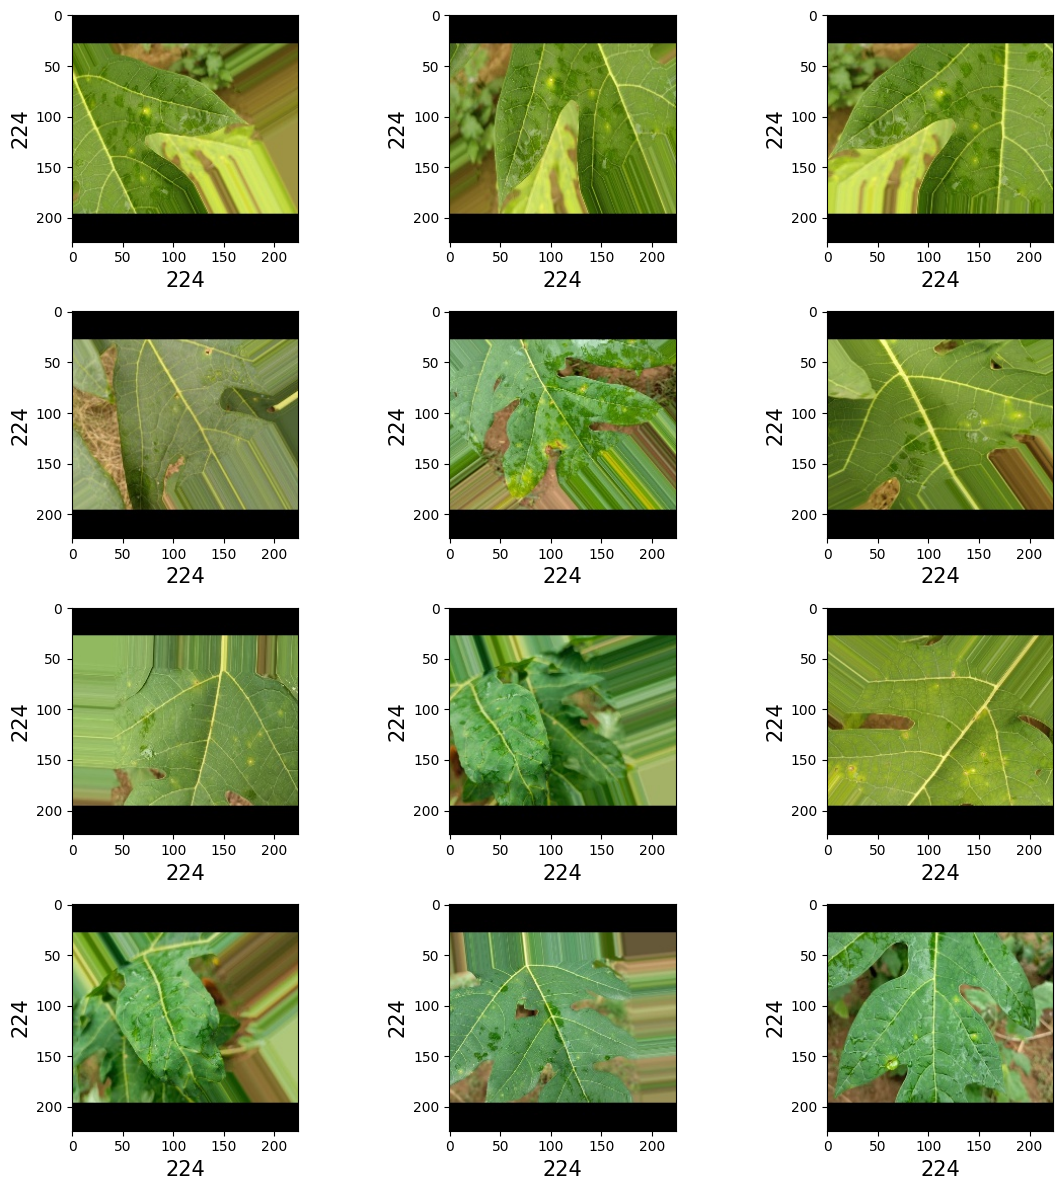

In [ ]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/Papya/RingSpot"
for i in range(1,13):
    plt.subplot(4,3,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 15)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 15)#height of image

In [ ]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (224,224))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
dir = "/content/drive/MyDrive/Papya"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['RingSpot', 'Healthy', 'Curl', 'BacterialSpot', 'Anthracnose']
binary_labels = [0, 1, 2, 3, 4]

# Reading and converting image to numpy array
for idx, directory in enumerate(root_dir):  # Using enumerate to handle indexing automatically
    plant_image_list = listdir(f"{dir}/{directory}")
    for files in plant_image_list:
        image_path = f"{dir}/{directory}/{files}"
        img_array = convert_image_to_array(image_path)
        if img_array is not None:  # Ensure the image was loaded correctly
            image_list.append(img_array)
            label_list.append(binary_labels[idx])  # Automatically assign the correct label

# Optionally print the loaded data summary
print(f"Loaded {len(image_list)} images across {len(all_labels)} classes.")

Loaded 4595 images across 5 classes.


In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

,count
0,
2,1070
3,922
4,882
1,861
0,860


In [ ]:
image_list[0].shape

(224, 224, 3)

In [ ]:
label_list = np.array(label_list)
label_list.shape

(4595,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.1, random_state = 10)

In [ ]:
#Normalizing the dataset
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape( -1, 224,224,3)
x_test = x_test.reshape( -1, 224,224,3)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
last_layer = base_model.get_layer('mixed7')
print('Last layer output:', last_layer.output)

last_output = last_layer.output

Last layer output: <KerasTensor shape=(None, 12, 12, 768), dtype=float32, sparse=False, name=keras_tensor_717>


In [ ]:
# Flatten the output layer to 1 dimension
x = Flatten()(last_output)
x = Dense(516, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 66,045,901 (251.95 MB)

 Trainable params: 57,069,605 (217.70 MB)

 Non-trainable params: 8,976,296 (34.24 MB)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.0001),metrics=['accuracy'])

In [ ]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/inceptionV3_model.weights.best.keras',  # Change to .keras
    verbose=1,
    save_best_only=True
)

In [ ]:
# Training the model
epochs = 25
batch_size = 256
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val, y_val), callbacks=[checkpointer], verbose=2, shuffle=True)

Epoch 1/25

Epoch 1: val_loss improved from inf to 1.69832, saving model to /content/drive/MyDrive/Colab Notebooks/inceptionV3_model.weights.best.keras
13/13 - 137s - 11s/step - accuracy: 0.7400 - loss: 1.7835 - val_accuracy: 0.7013 - val_loss: 1.6983
Epoch 2/25

Epoch 2: val_loss improved from 1.69832 to 1.43447, saving model to /content/drive/MyDrive/Colab Notebooks/inceptionV3_model.weights.best.keras
13/13 - 78s - 6s/step - accuracy: 0.9831 - loss: 0.9837 - val_accuracy: 0.8065 - val_loss: 1.4345
Epoch 3/25

Epoch 3: val_loss improved from 1.43447 to 1.26567, saving model to /content/drive/MyDrive/Colab Notebooks/inceptionV3_model.weights.best.keras
13/13 - 75s - 6s/step - accuracy: 0.9943 - loss: 0.8757 - val_accuracy: 0.8440 - val_loss: 1.2657
Epoch 4/25

Epoch 4: val_loss improved from 1.26567 to 1.12640, saving model to /content/drive/MyDrive/Colab Notebooks/inceptionV3_model.weights.best.keras
13/13 - 77s - 6s/step - accuracy: 1.0000 - loss: 0.8216 - val_accuracy: 0.9057 - val

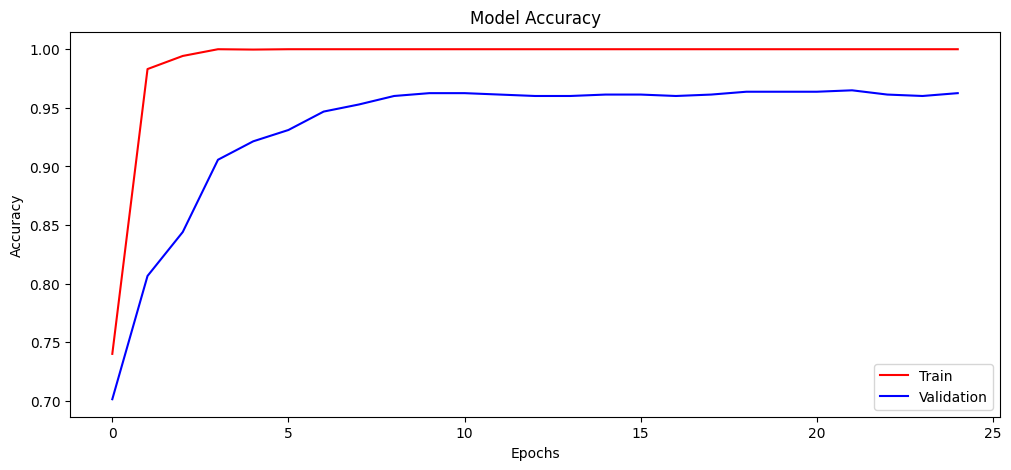

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])

plt.show()

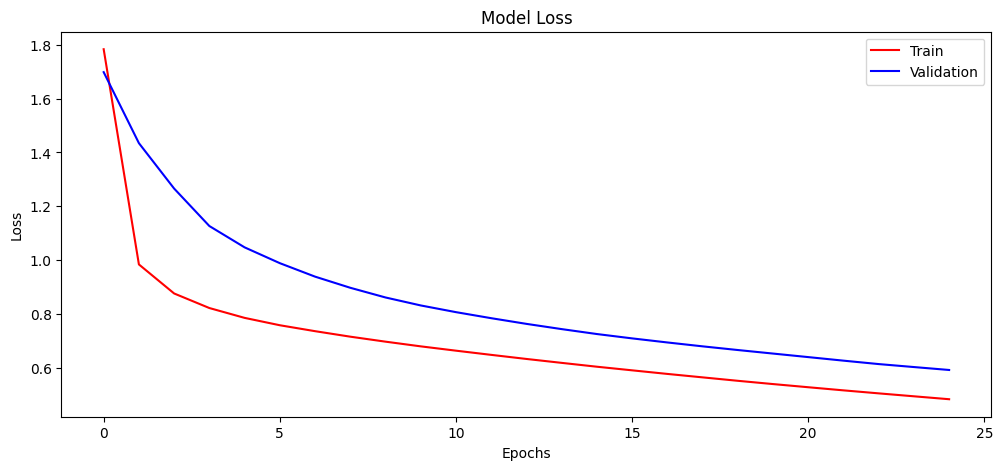

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - accuracy: 0.9781 - loss: 0.5705
Test Accuracy: 97.6086974143982


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('/content/drive/MyDrive/Colab Notebooks/inceptionV3_model.weights.best.keras')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true is the true labels and y_pred is the model's predicted labels
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)  # Get the class with highest probability
y_true_classes = y_test.argmax(axis=1)  # If y_test is one-hot encoded

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Calculate individual metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        91
           1       0.98      0.99      0.98        97
           2       0.95      0.99      0.97       106
           3       0.99      0.95      0.97        79
           4       0.99      0.98      0.98        87

    accuracy                           0.98       460
   macro avg       0.98      0.97      0.98       460
weighted avg       0.98      0.98      0.98       460

Accuracy: 0.9760869565217392
Precision: 0.9763671794166826
Recall: 0.9760869565217392
F1 Score: 0.9760703871555353


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


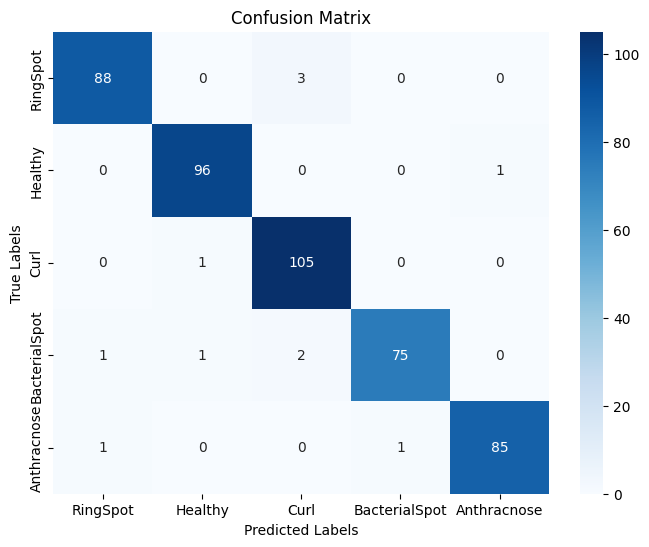

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
y_pred = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()